In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from calibrated_explanations import CalibratedExplainer, VennAbers
from lime.lime_tabular import LimeTabularExplainer

In [7]:

dataSet = 'glass'
delimiter = ','
num_to_test = 12
print(dataSet)

fileName = '../data/Multiclass/' + dataSet + ".csv"
df = pd.read_csv(fileName, delimiter=delimiter)
target = 'Type'

df = df.dropna()
categorical_features = []
categorical_labels = {}
for c, col in enumerate(df.columns):
    if df[col].dtype == object:
        df[col] = df[col].str.replace("'", "")
        df[col] = df[col].str.replace('"', '')
        if col != target:
            categorical_features.append(c)
            categorical_labels[c] = dict(zip(range(len(np.unique(df[col]))),np.unique(df[col])))
        else:
            target_labels = dict(zip(range(len(np.unique(df[col]))),np.unique(df[col])))
        mapping = dict(zip(np.unique(df[col]), range(len(np.unique(df[col])))))
        if len(mapping) > 5:
            counts = df[col].value_counts().sort_values(ascending=False)
            id = 0
            for key, count in counts.items():
                if count > 5:
                    id += 1
                    continue
                mapping[key] = id
        df[col] = df[col].map(mapping)
print(target_labels)

glass
{0: 'build wind float', 1: 'build wind non-float', 2: 'containers', 3: 'headlamps', 4: 'tableware', 5: 'vehic wind float'}


In [8]:
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.51793,12.79,3.50,1.12,73.03,0.64,8.77,0.0,0.00,0
1,1.51643,12.16,3.52,1.35,72.89,0.57,8.53,0.0,0.00,5
2,1.51793,13.21,3.48,1.41,72.64,0.59,8.43,0.0,0.00,0
3,1.51299,14.40,1.74,1.54,74.55,0.00,7.59,0.0,0.00,4
4,1.53393,12.30,0.00,1.00,70.16,0.12,16.19,0.0,0.24,1


In [9]:
X, y = df.drop(target,axis=1), df[target] 
no_of_classes = len(np.unique(y))
no_of_features = X.shape[1]
no_of_instances = X.shape[0]
# sort targets to make sure equal presence of both classes in test set (see definition of test_index after outer loop below)
idx = np.argsort(y.values).astype(int)
X, y = X.values[idx,:], y.values[idx]
test_idx = []
idx = list(range(no_of_instances))
for i in range(no_of_classes):
    test_idx.append(np.where(y == i)[0][0:int(num_to_test/no_of_classes)])
test_index = np.array(test_idx).flatten()
# Select num_to_test/2 from top and num_to_test/2 from bottom of list of instances
train_index = np.setdiff1d(np.array(range(no_of_instances)), test_index)   
trainCalX, testX = X[train_index,:], X[test_index,:]
trainCalY, testY = y[train_index], y[test_index]
trainX, calX, trainY, calY = train_test_split(trainCalX, trainCalY, test_size=0.33,random_state=42, stratify=trainCalY)
print(testY)
print(categorical_features)

[0 0 1 1 2 2 3 3 4 4 5 5]
[]


In [10]:
model = RandomForestClassifier(n_estimators=100)
model_name = 'RF' 
model.fit(trainX,trainY)  

RandomForestClassifier()

In [11]:
va = VennAbers(calX, calY, model)
va_preds = va.predict(testX)
va_proba, low, high, classes = va.predict_proba(testX, output_interval=True)
print(*zip(low, va_proba[:,1],high, va_preds, testY, classes),sep='\n')  

(0.8387096774193549, 0.8611111111111113, 1.0, 1.0, 0, 0)
(0.8387096774193549, 0.84375, 0.8709677419354839, 1.0, 0, 0)
(0.8387096774193549, 0.84375, 0.8709677419354839, 1.0, 1, 1)
(0.5454545454545454, 0.5652173913043479, 0.5909090909090909, 1.0, 1, 1)
(0.8387096774193549, 0.84375, 0.8709677419354839, 1.0, 2, 3)
(0.7142857142857143, 0.75, 0.8571428571428571, 1.0, 2, 2)
(0.9090909090909091, 0.9166666666666667, 1.0, 1.0, 3, 3)
(0.8387096774193549, 0.84375, 0.8709677419354839, 1.0, 3, 3)
(0.8387096774193549, 0.84375, 0.8709677419354839, 1.0, 4, 4)
(0.0, 0.37142857142857144, 0.5909090909090909, 0.0, 4, 4)
(0.5454545454545454, 0.5652173913043479, 0.5909090909090909, 1.0, 5, 0)
(0.5454545454545454, 0.5652173913043479, 0.5909090909090909, 1.0, 5, 1)


In [12]:
ce = CalibratedExplainer(model, calX, calY, \
                    feature_names=df.columns, \
                    categorical_features=categorical_features, class_labels=target_labels)

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


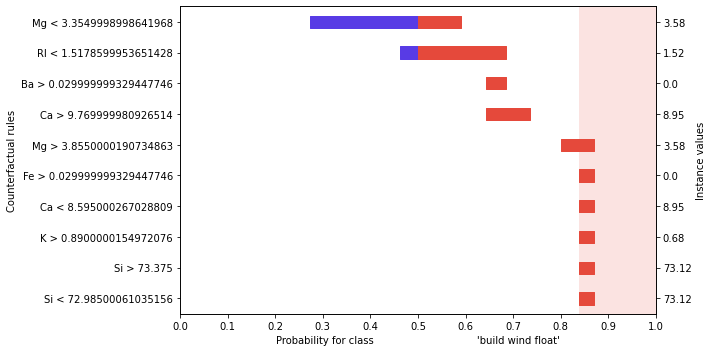

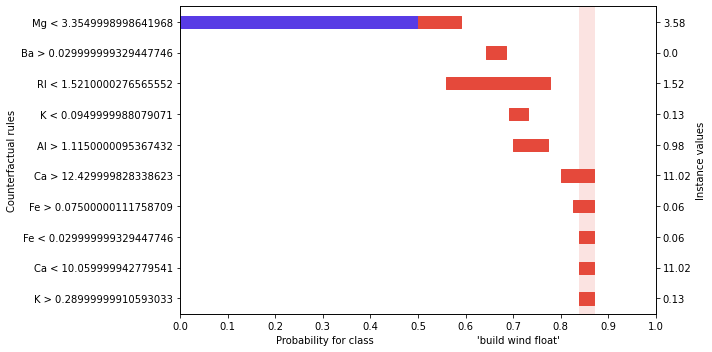

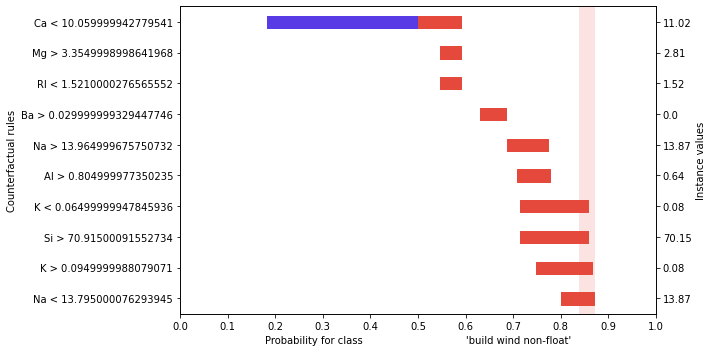

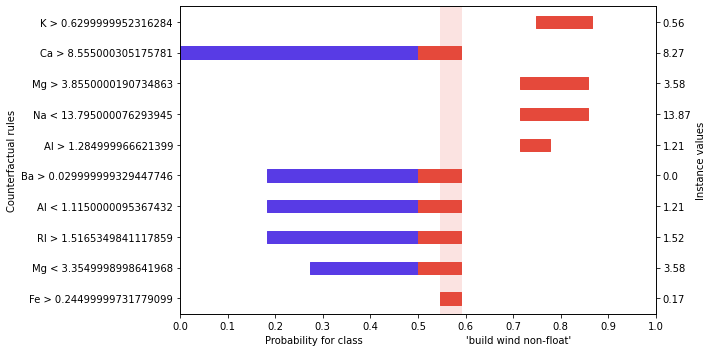

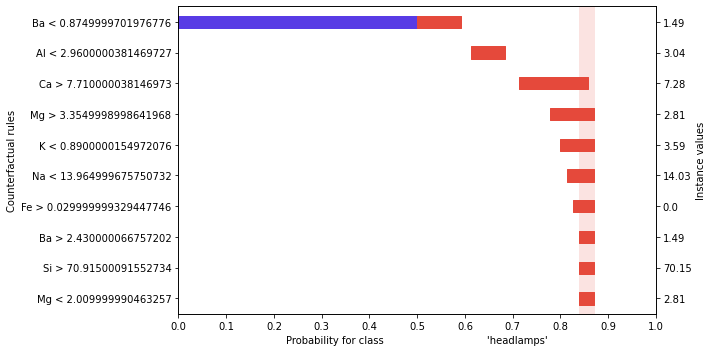

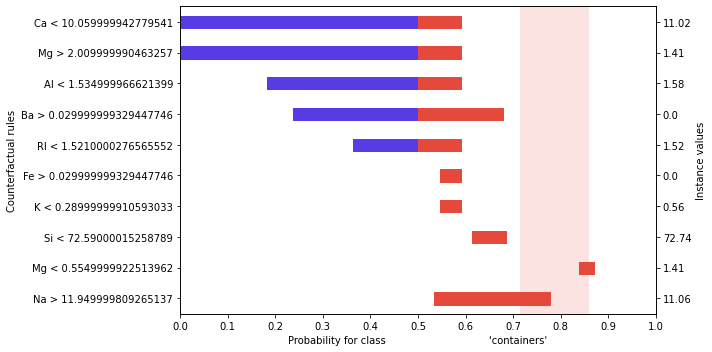

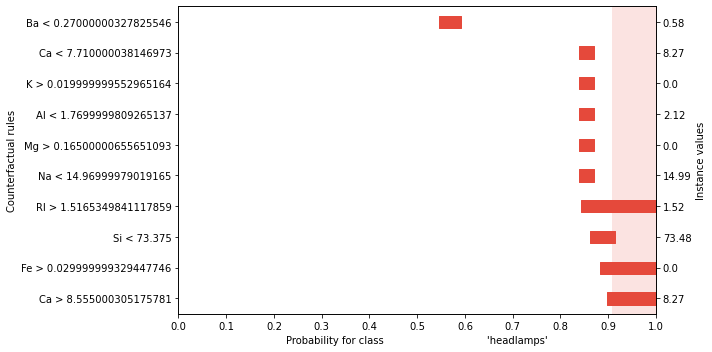

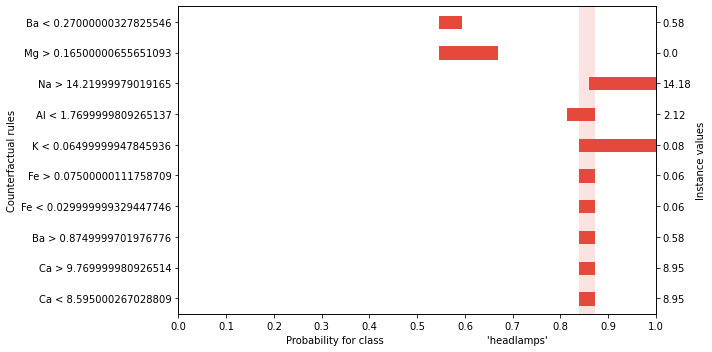

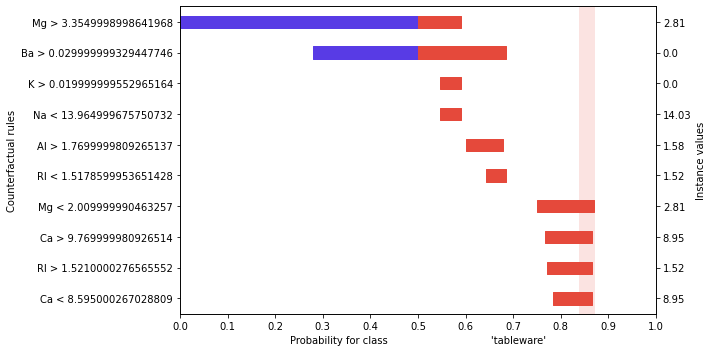

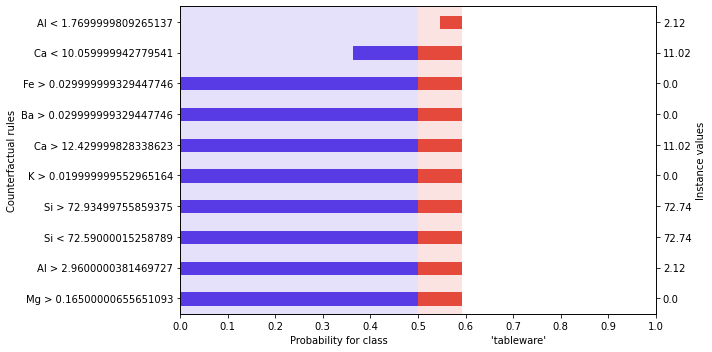

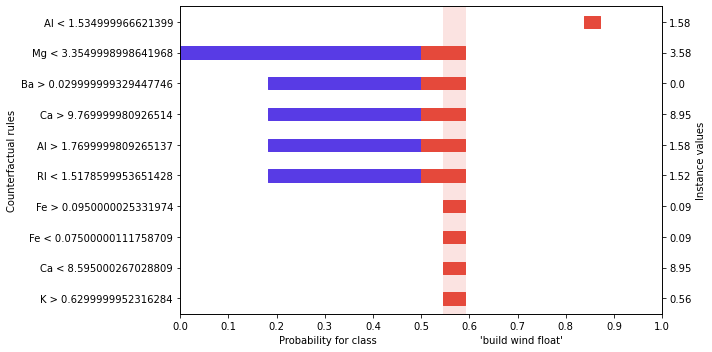

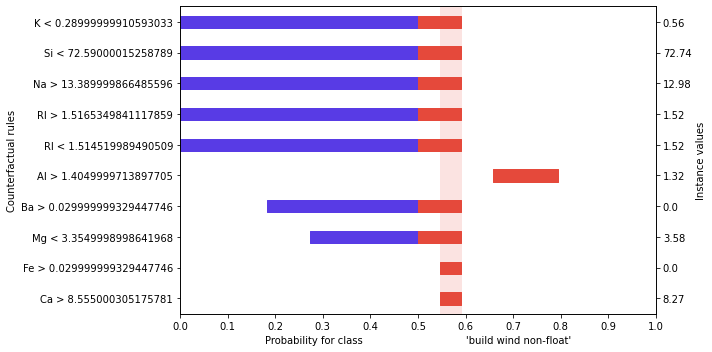

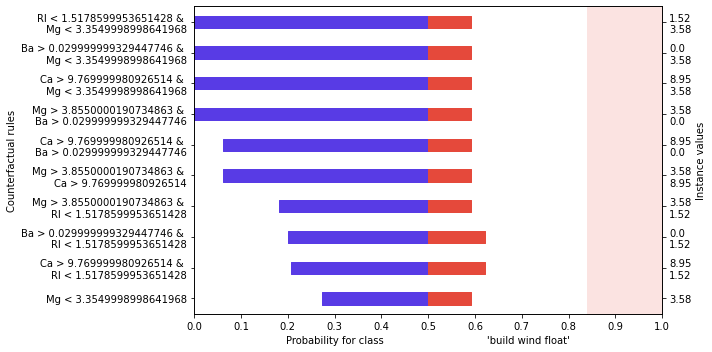

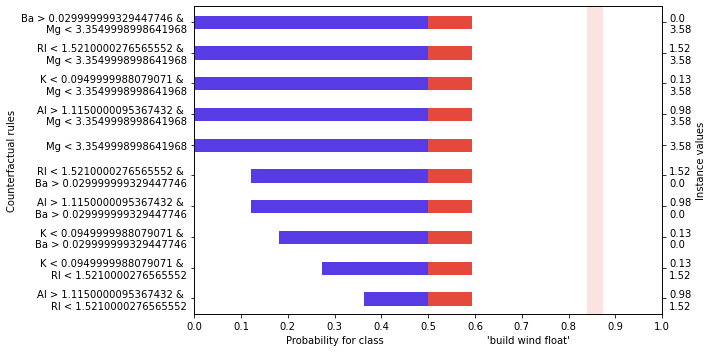

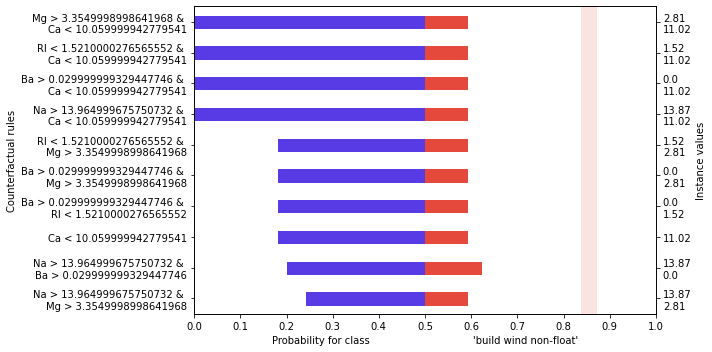

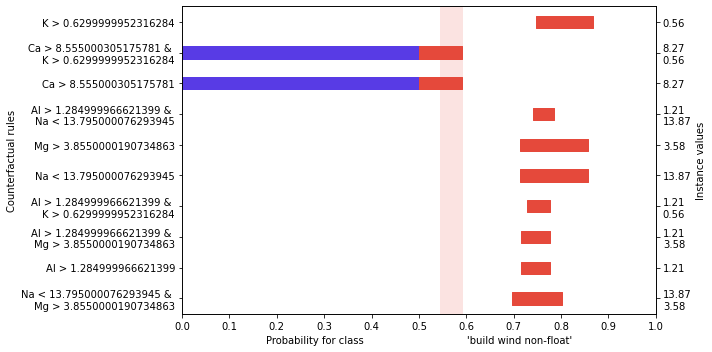

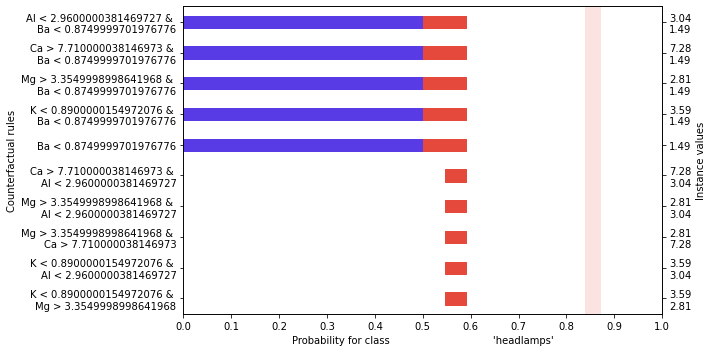

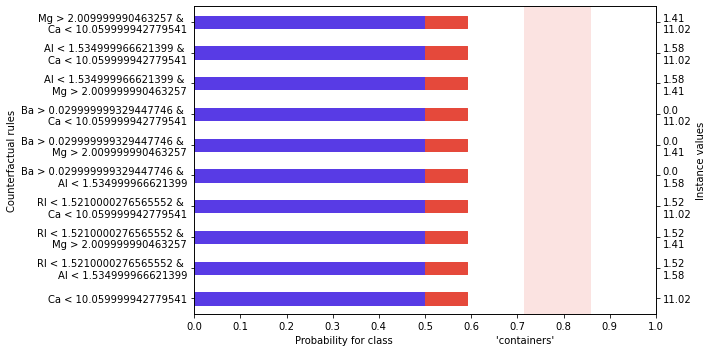

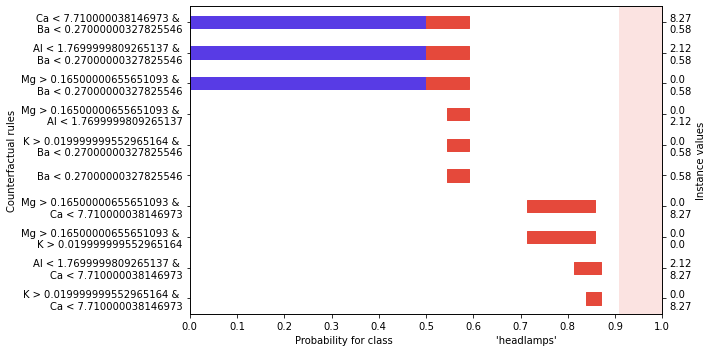

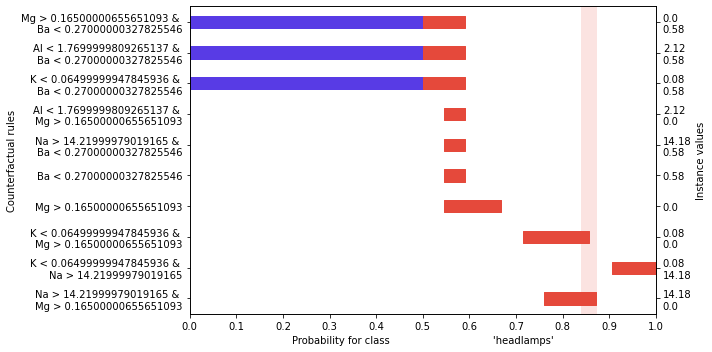

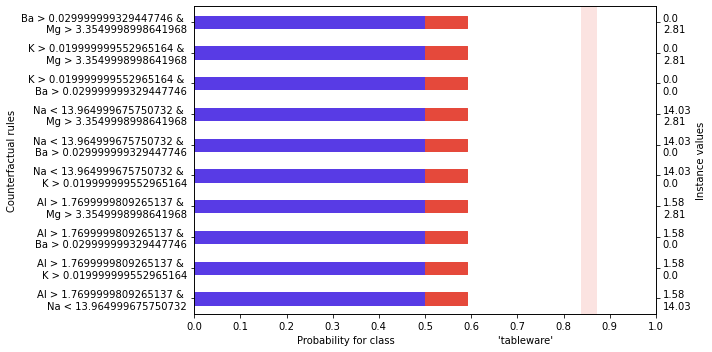

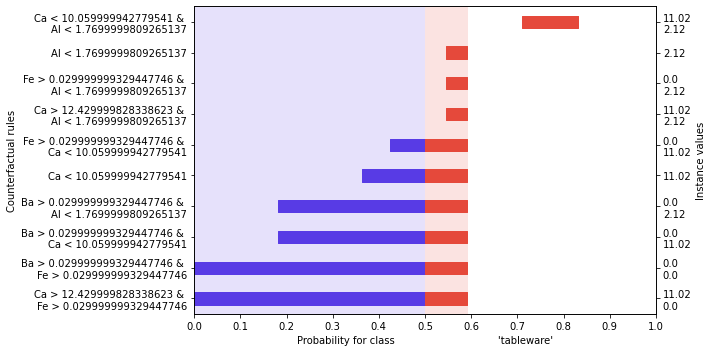

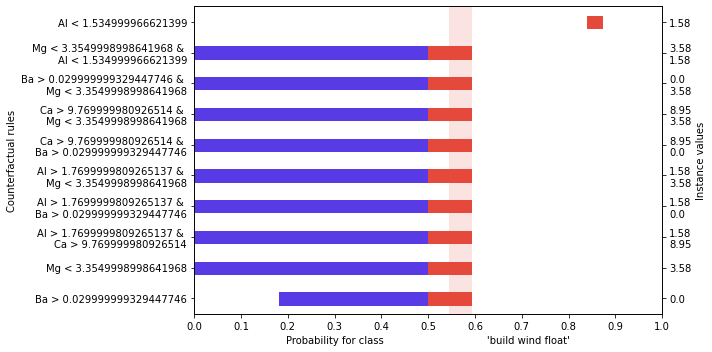

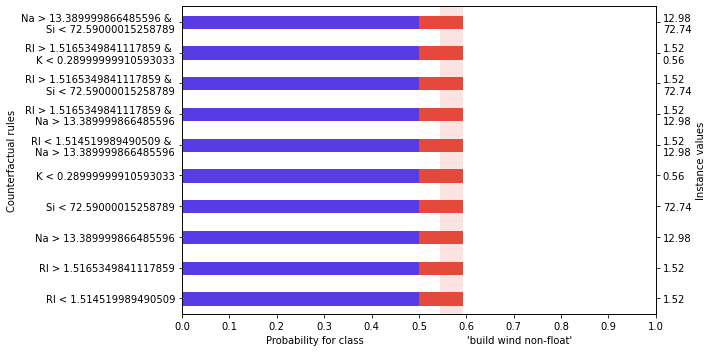

In [13]:
discretizer = 'entropy'
ce.set_discretizer(discretizer)
exp = ce(testX)
exp.plot_counterfactuals()
exp.add_conjunctive_counterfactual_rules().plot_counterfactuals()

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


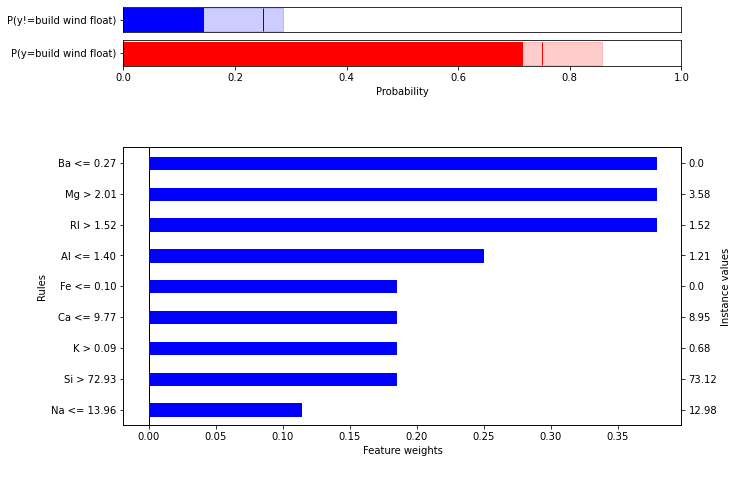

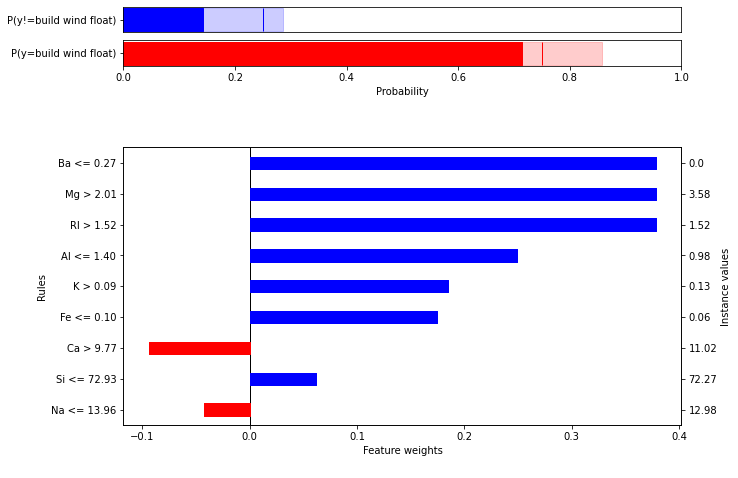

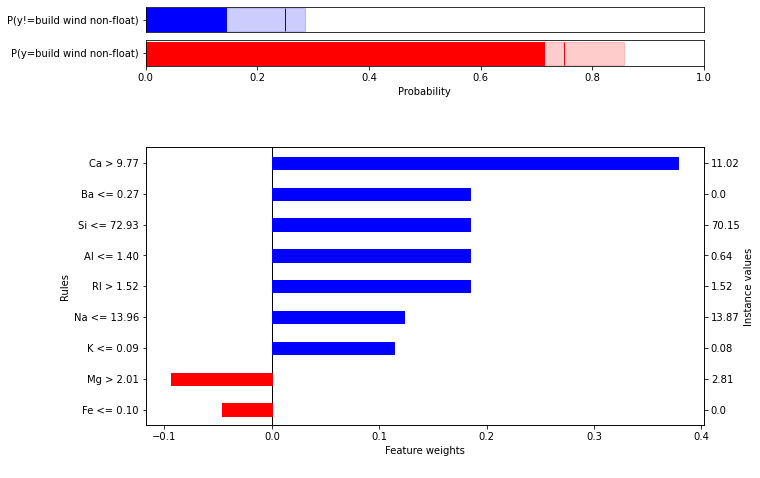

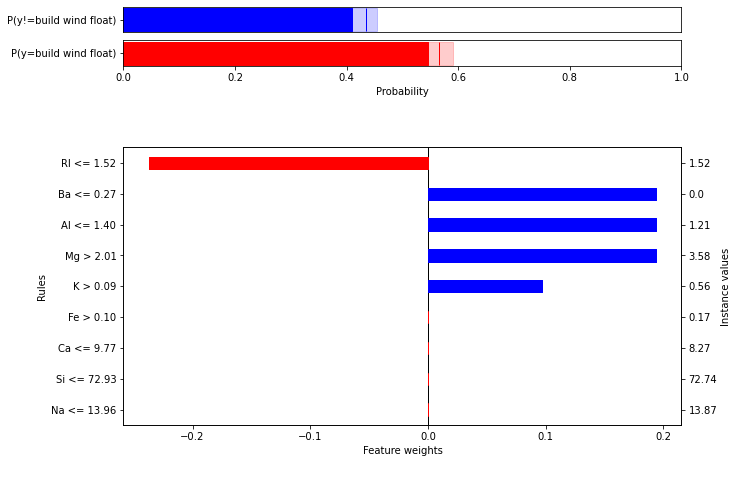

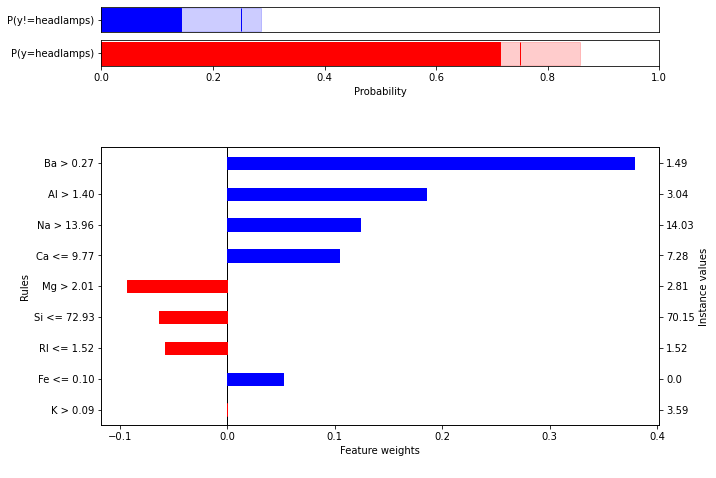

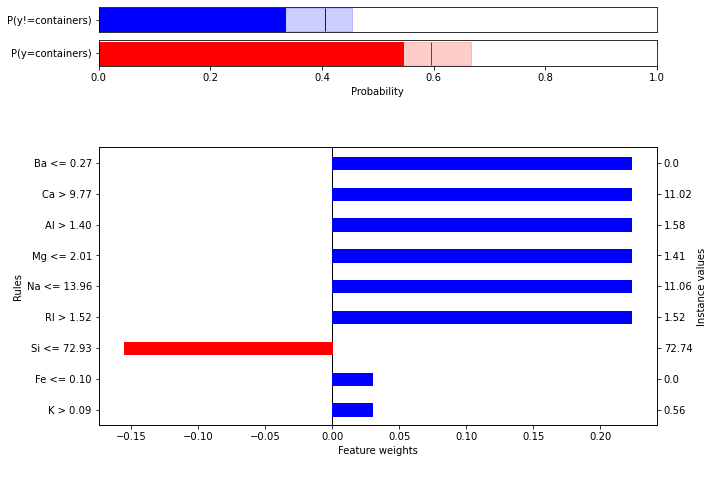

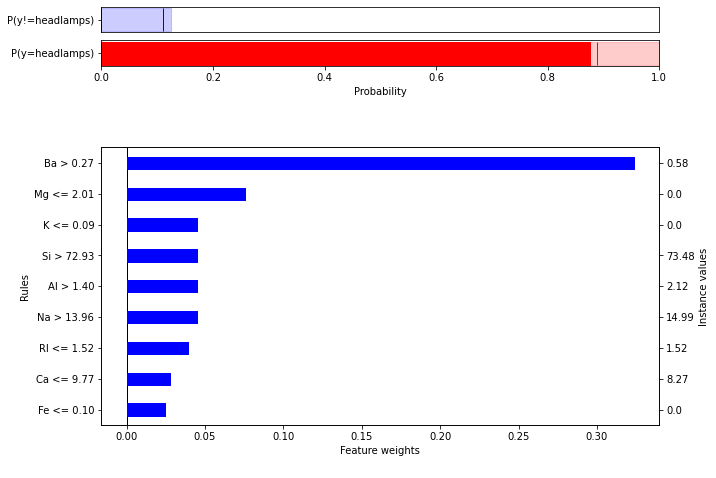

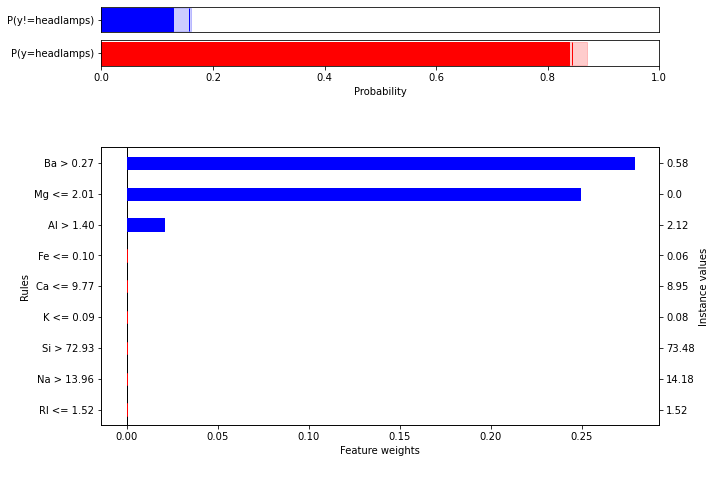

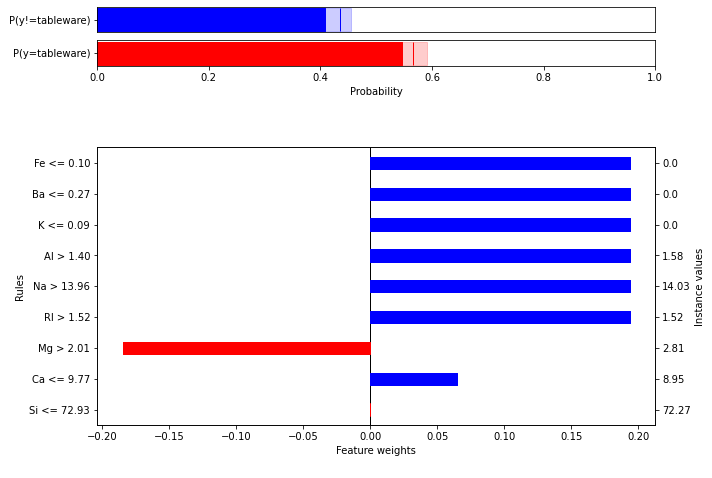

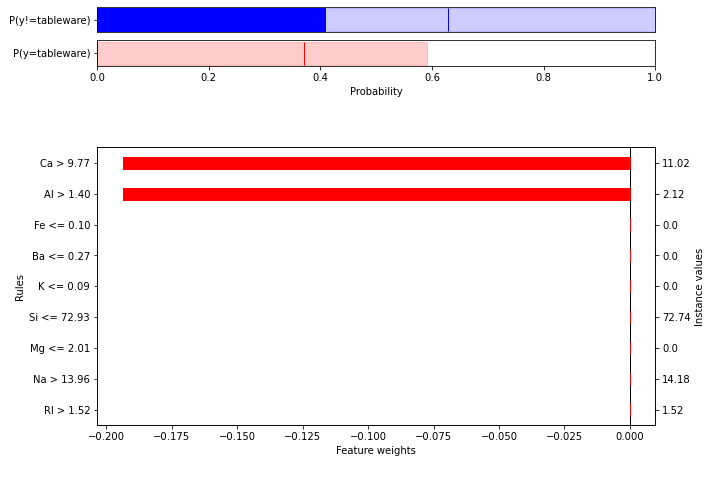

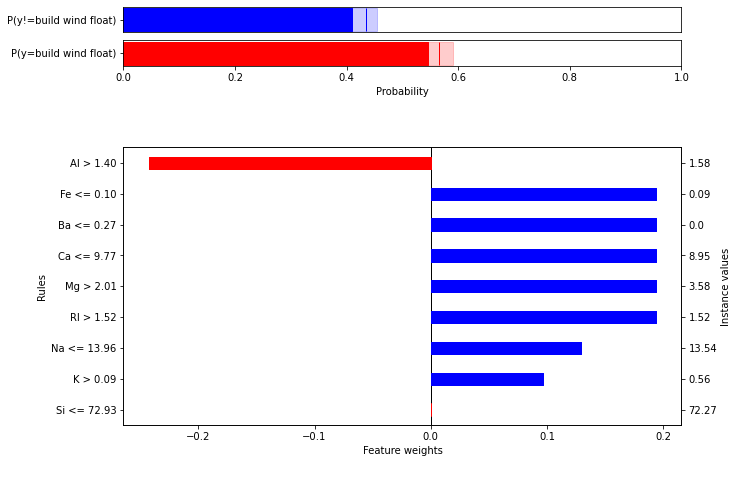

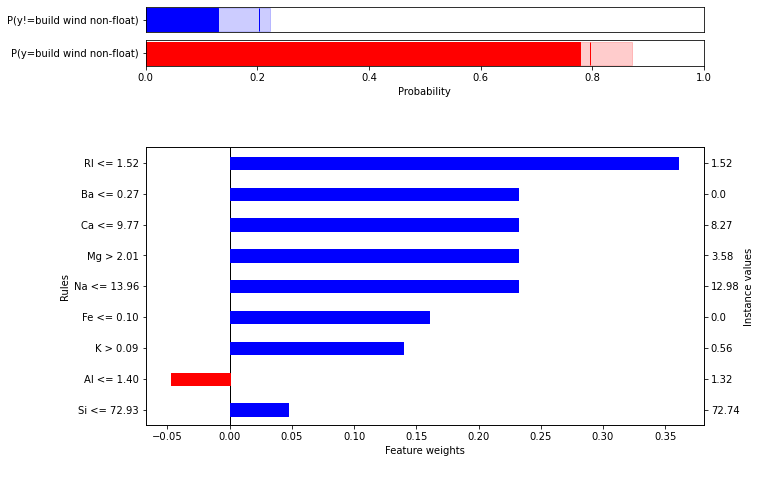

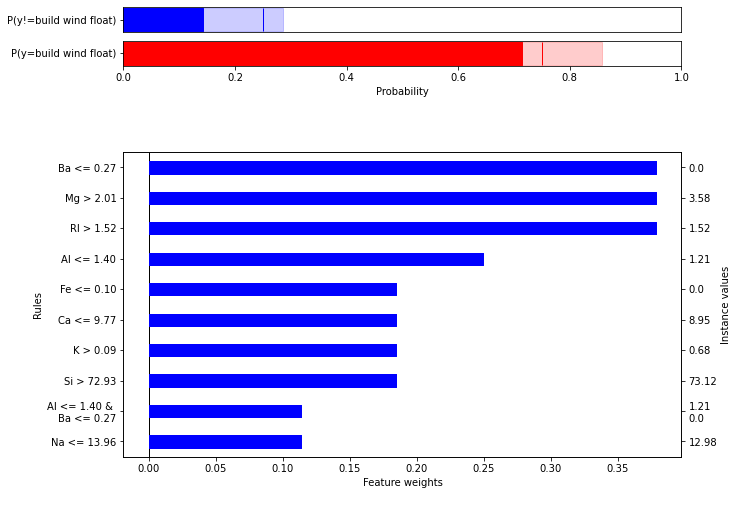

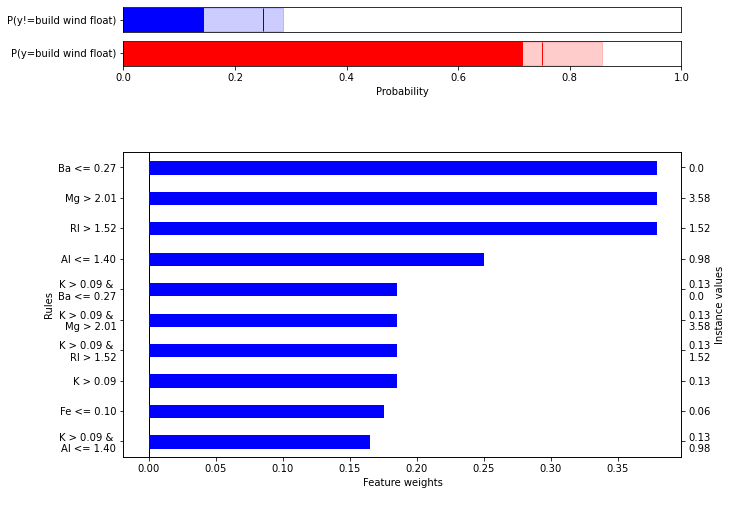

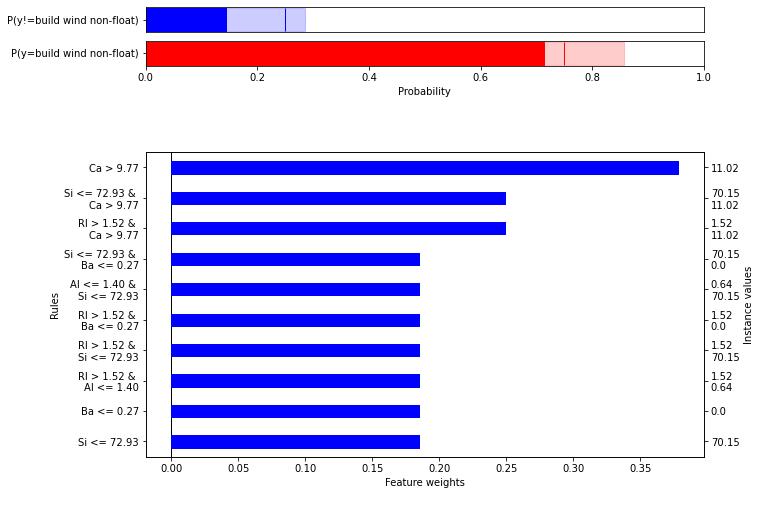

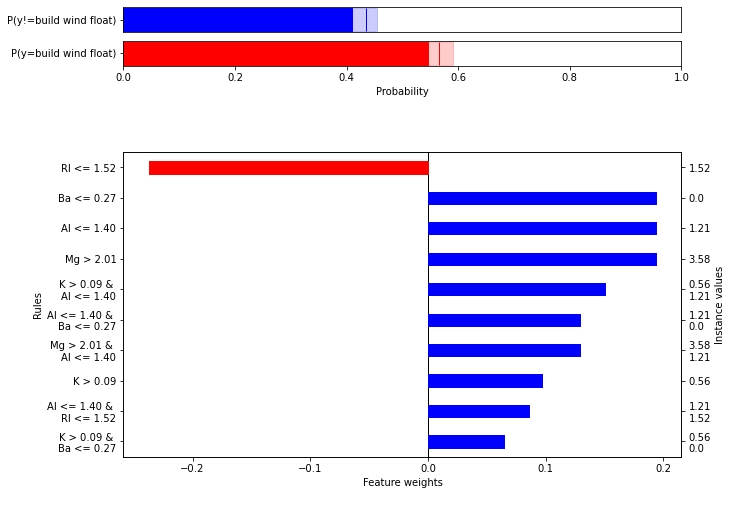

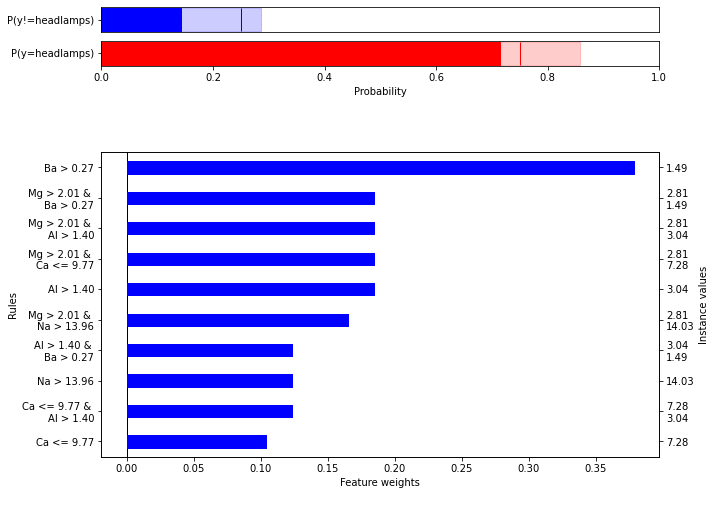

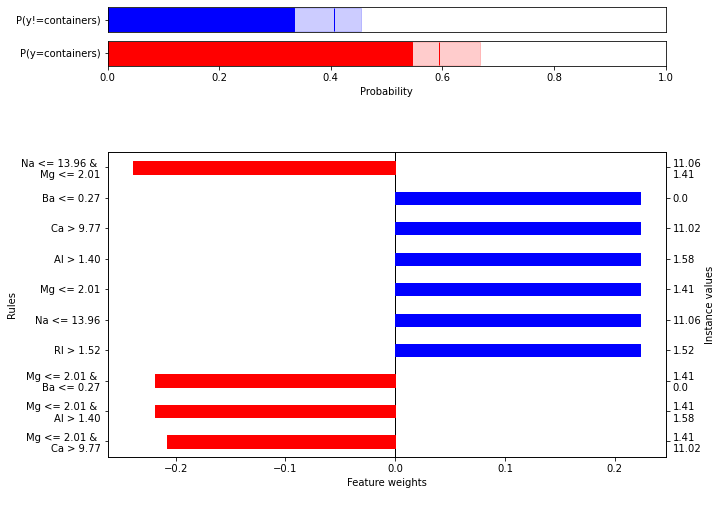

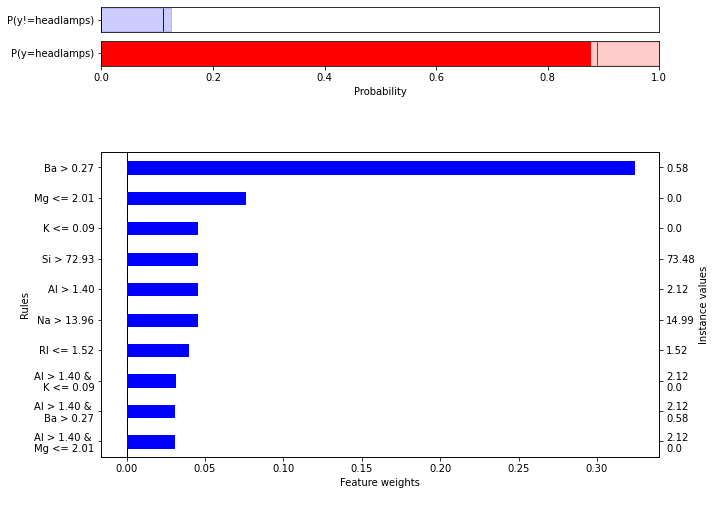

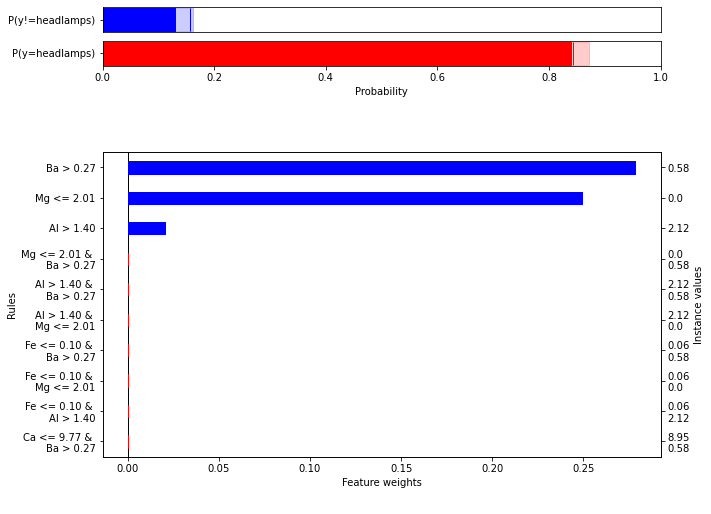

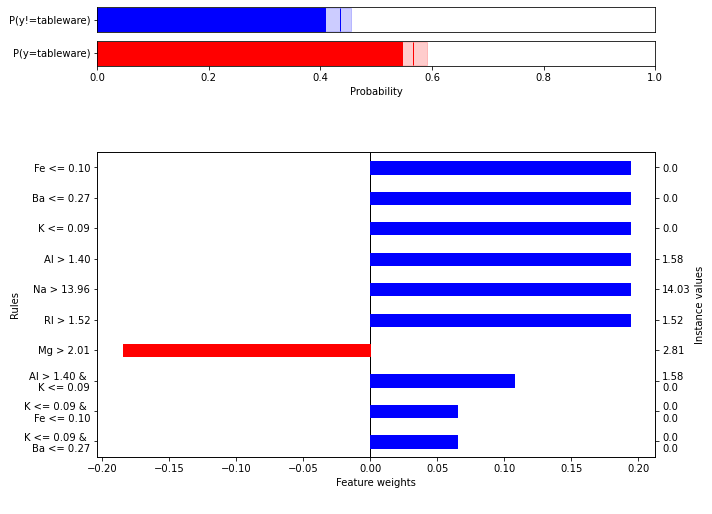

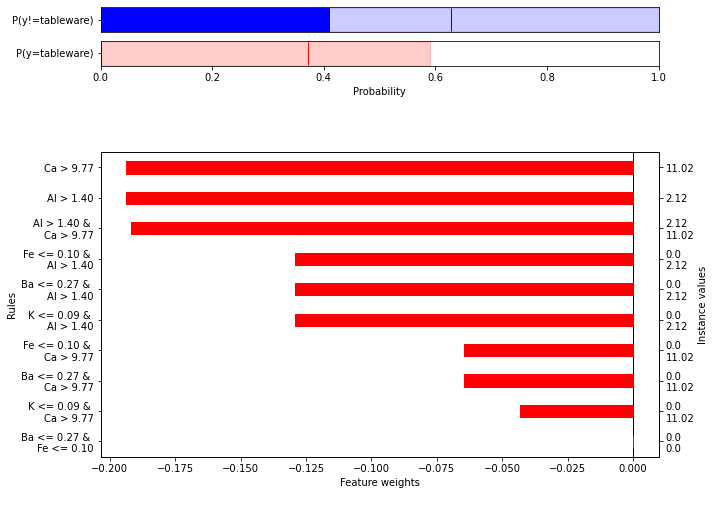

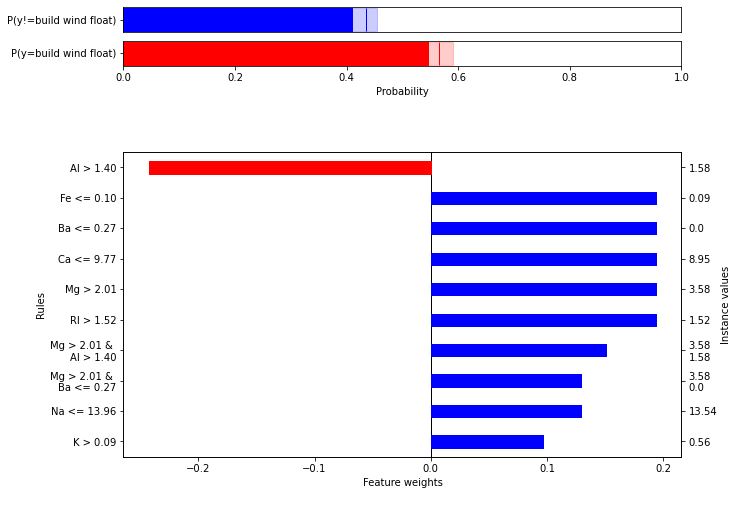

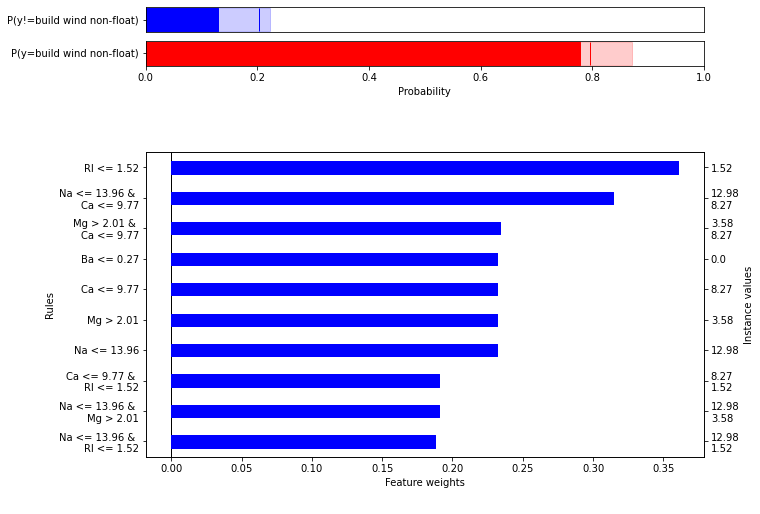

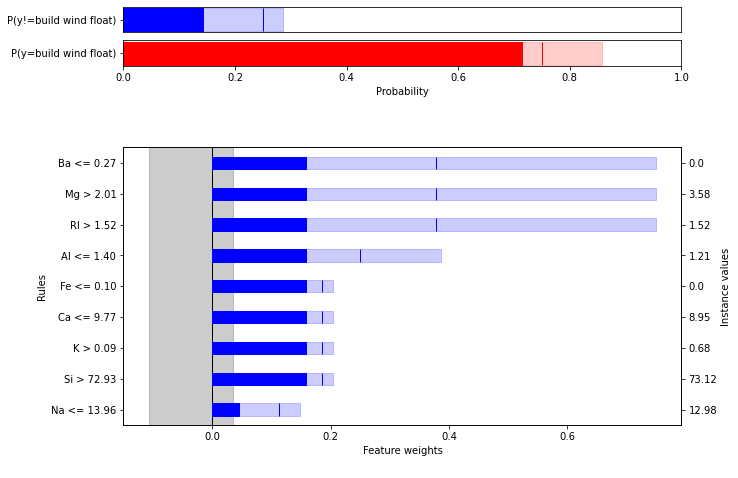

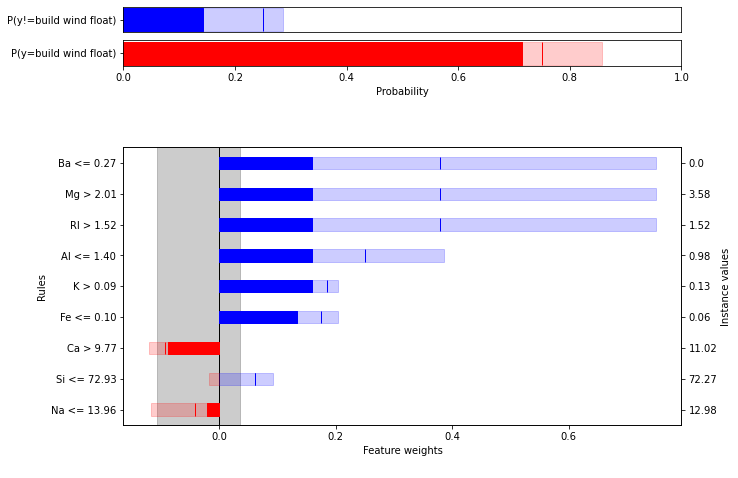

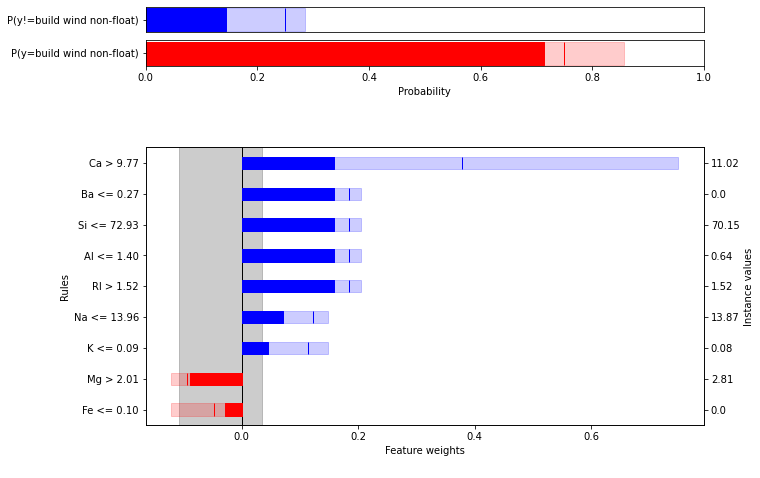

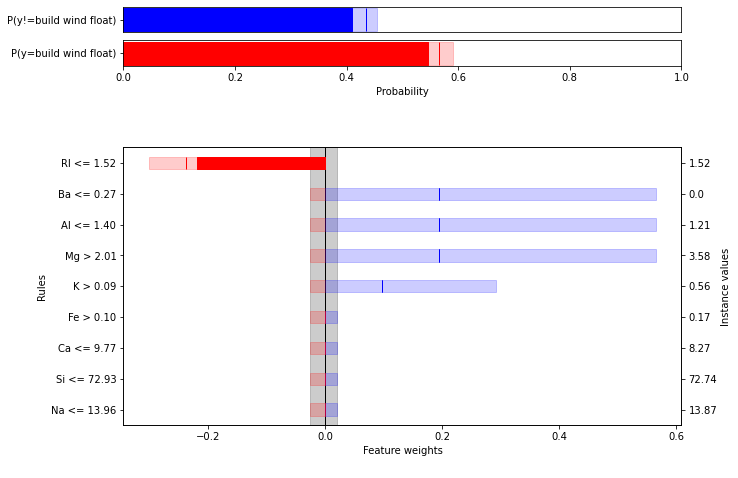

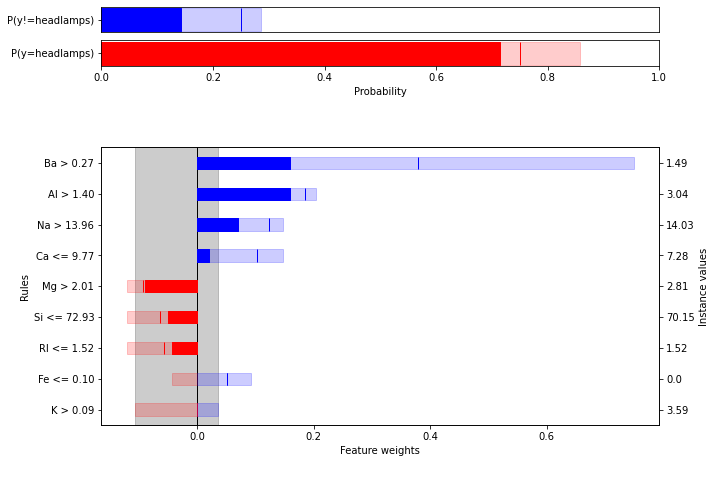

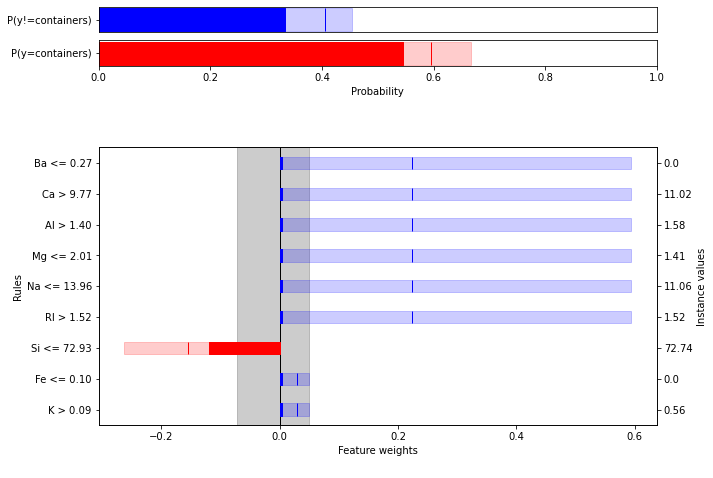

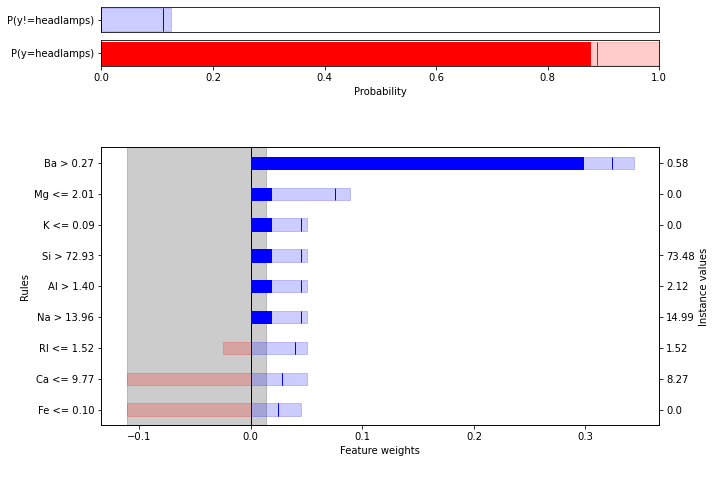

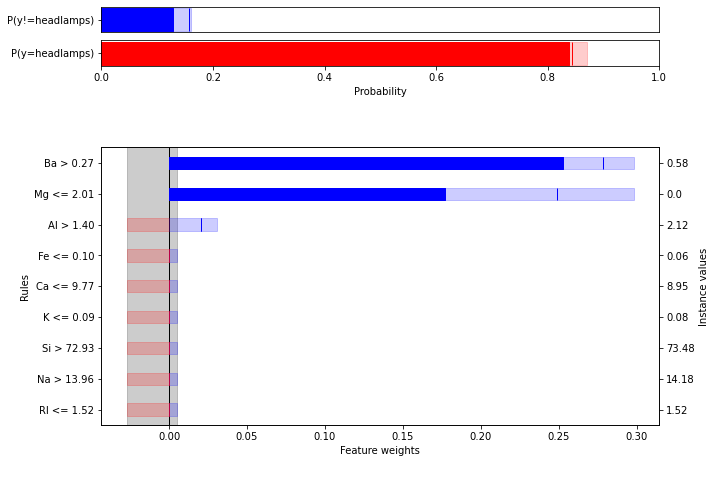

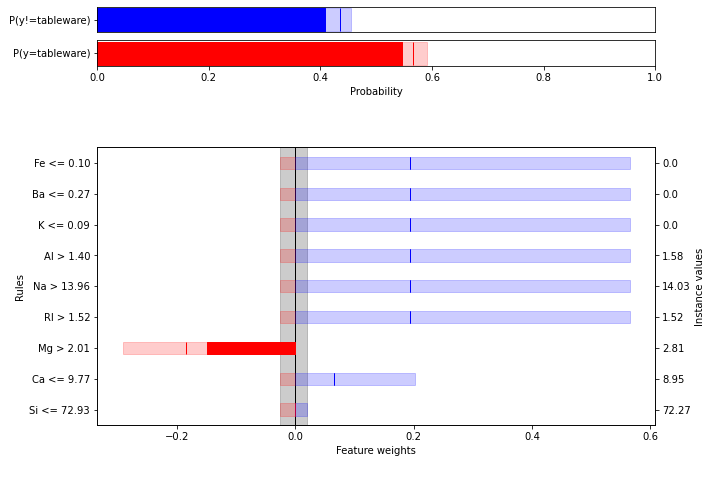

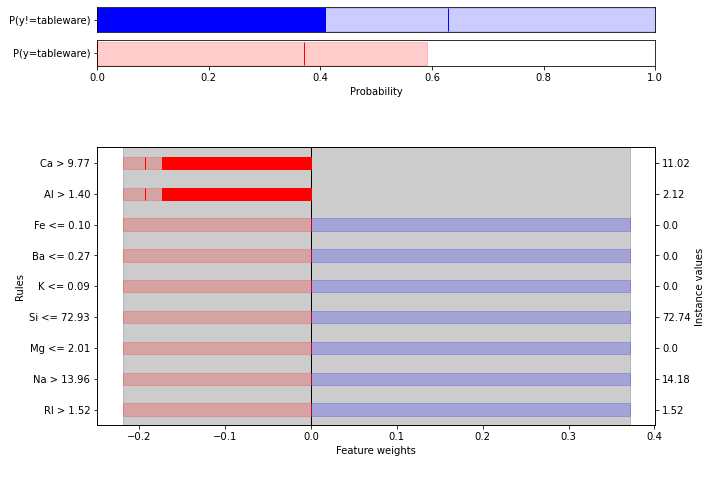

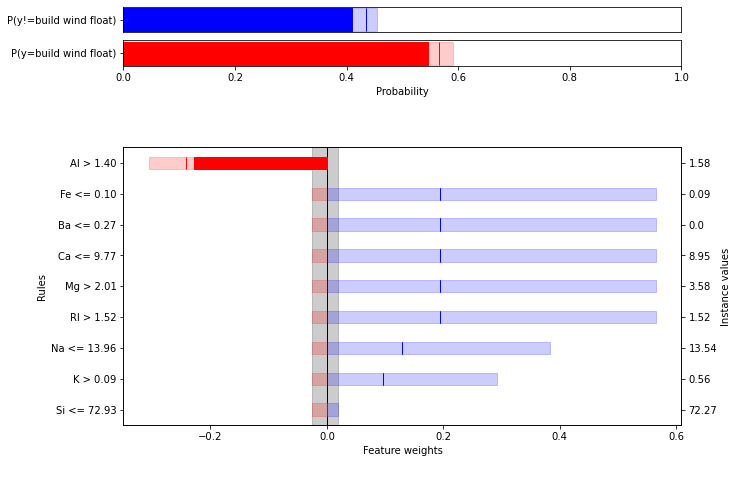

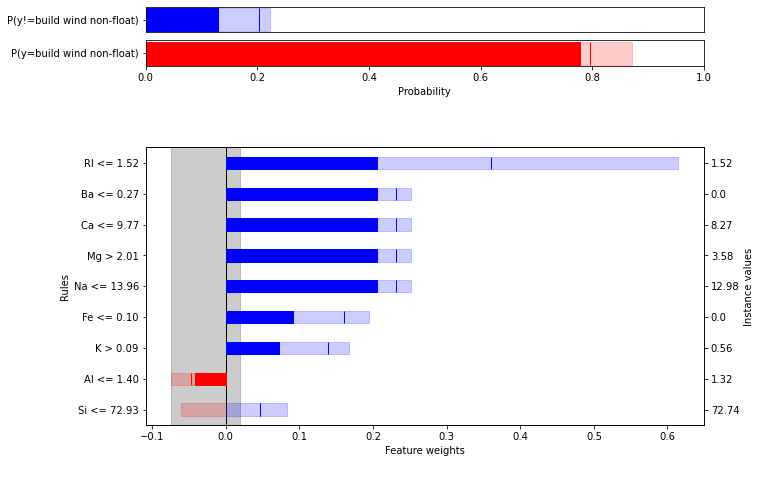

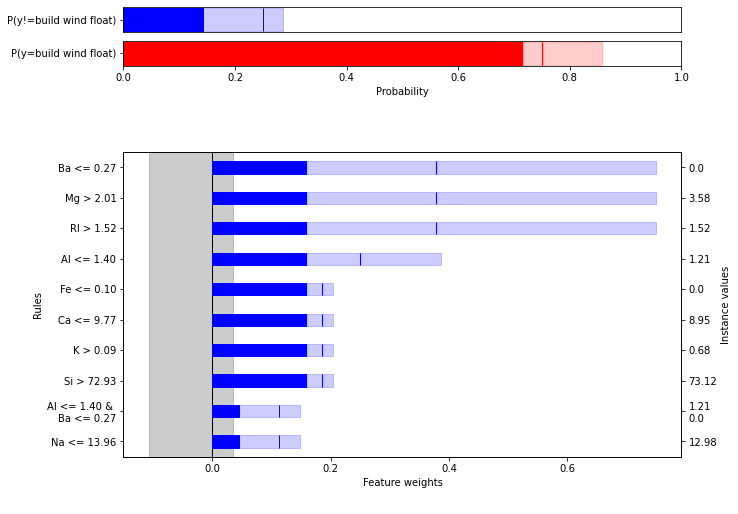

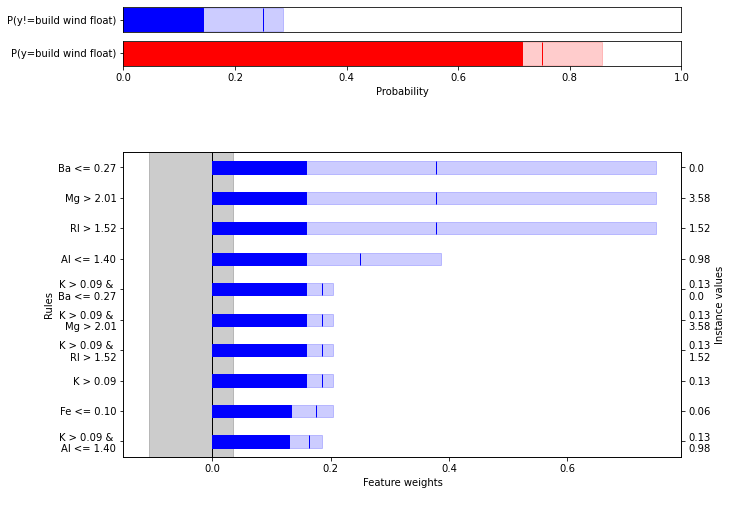

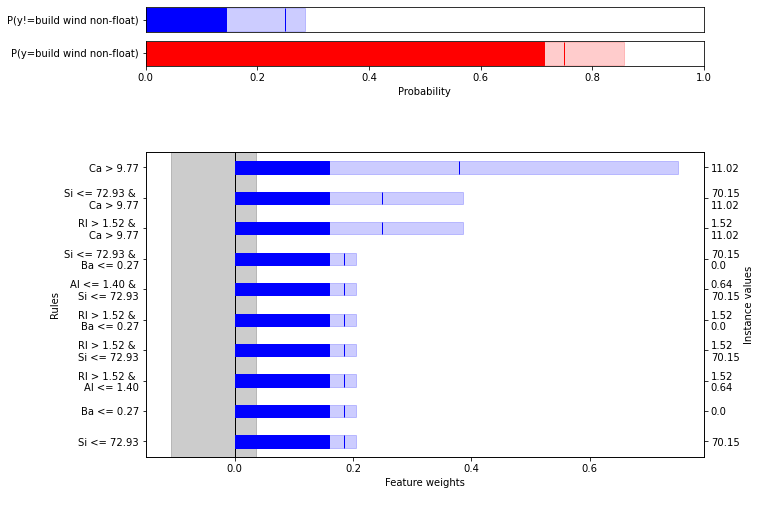

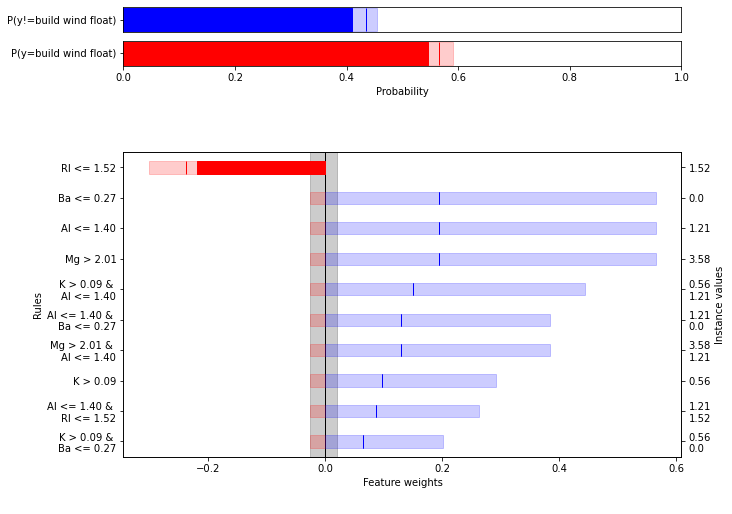

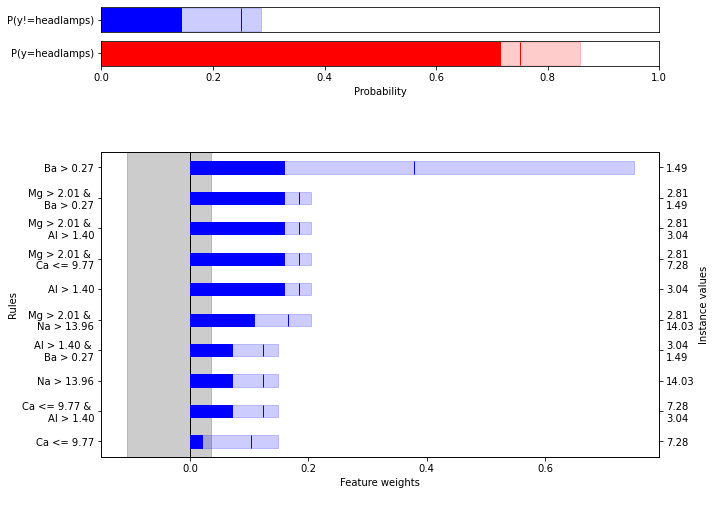

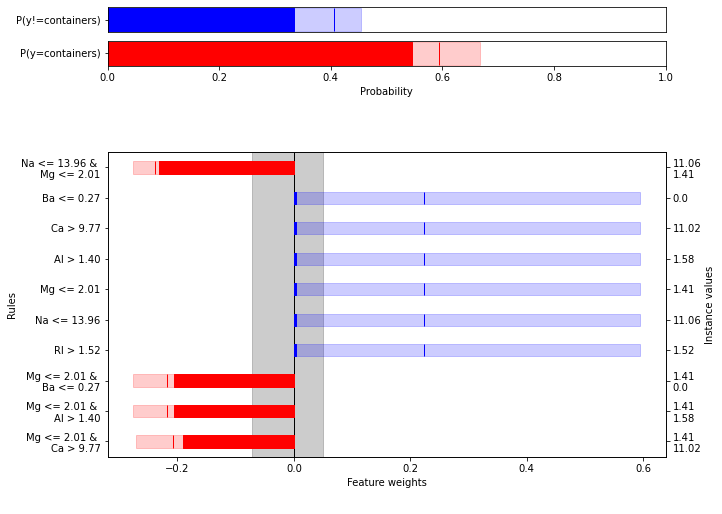

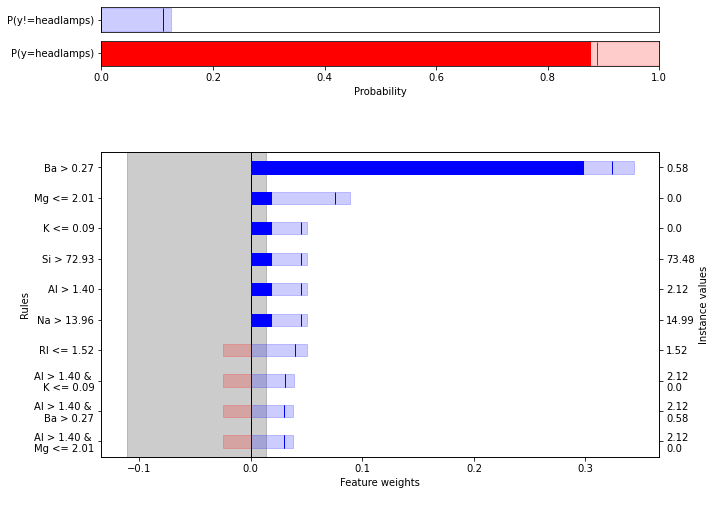

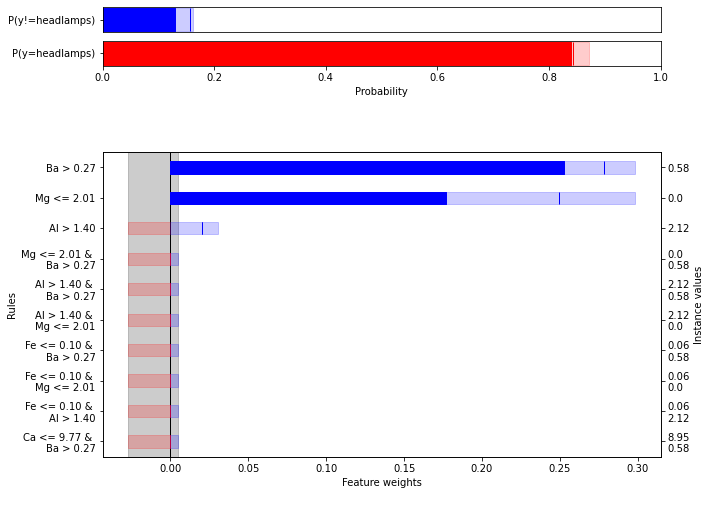

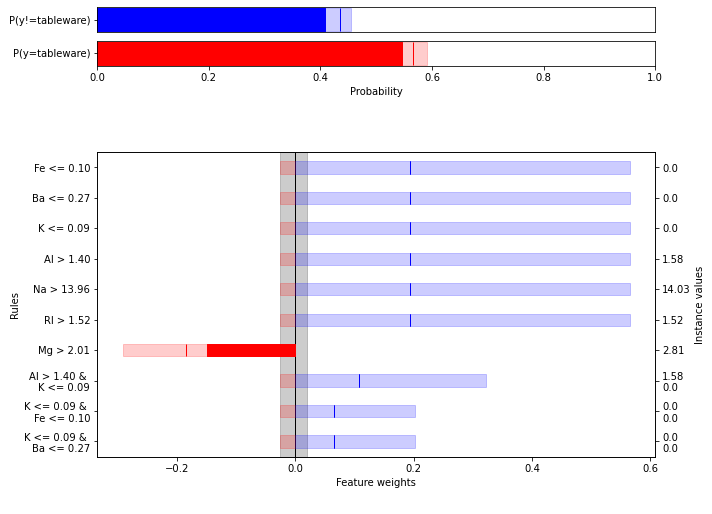

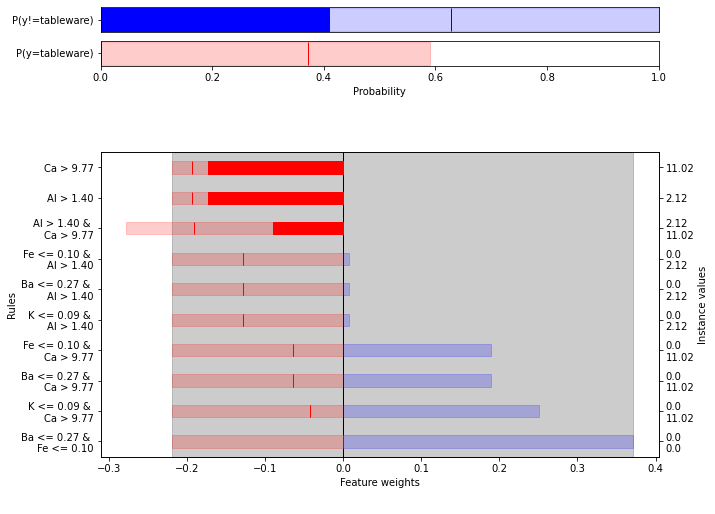

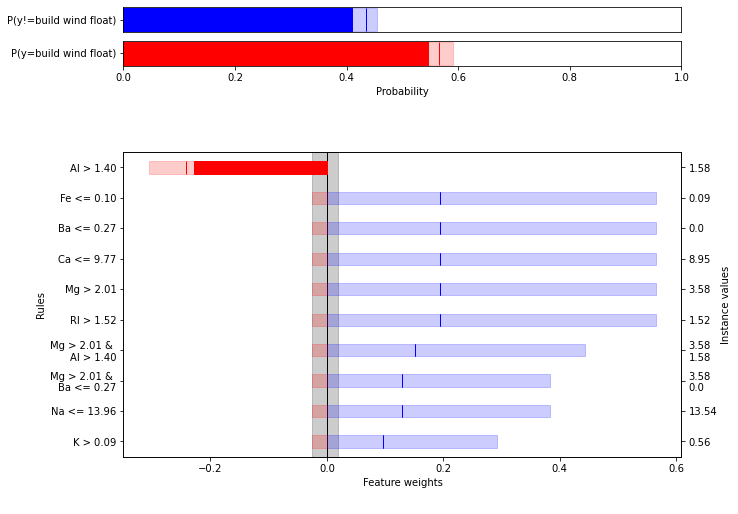

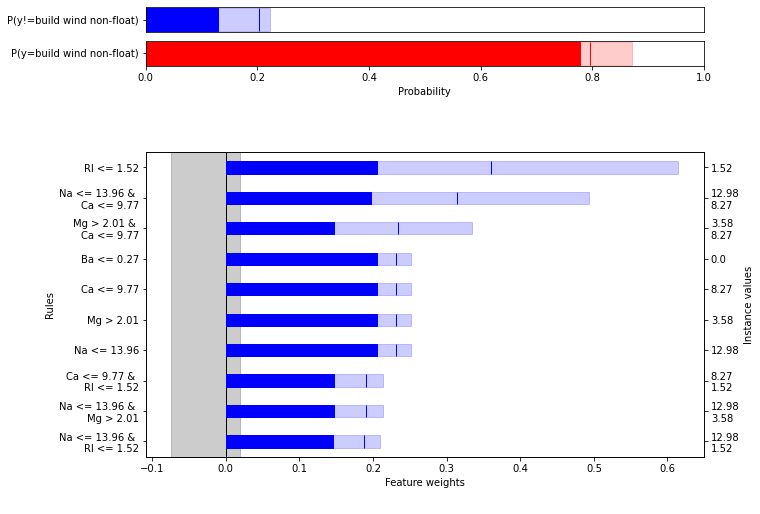

In [14]:
discretizer = 'binaryEntropy'#,,]:#'entropy','quartile','decile','binary',
ce.set_discretizer(discretizer)
exp = ce(testX)
exp.plot_regular()
exp.add_conjunctive_factual_rules().plot_regular()
exp.remove_conjunctive_rules()
exp.plot_uncertainty()
exp.add_conjunctive_factual_rules().plot_uncertainty()

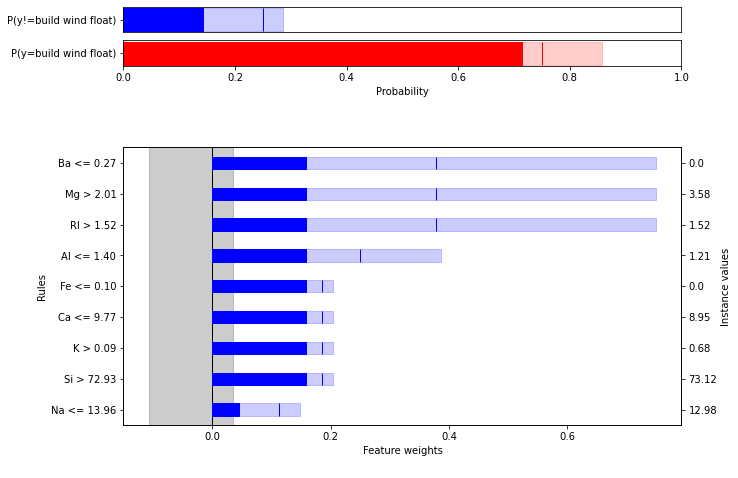

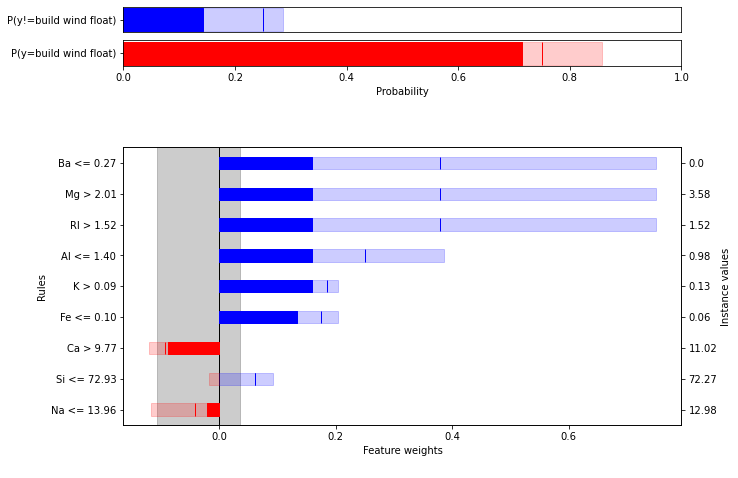

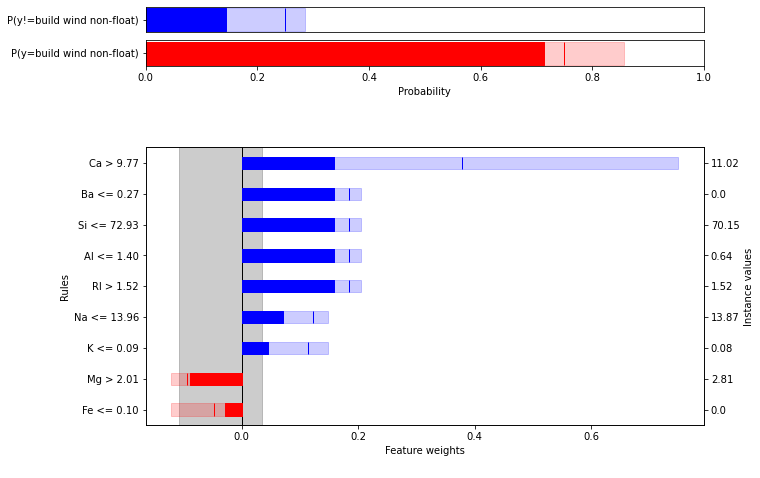

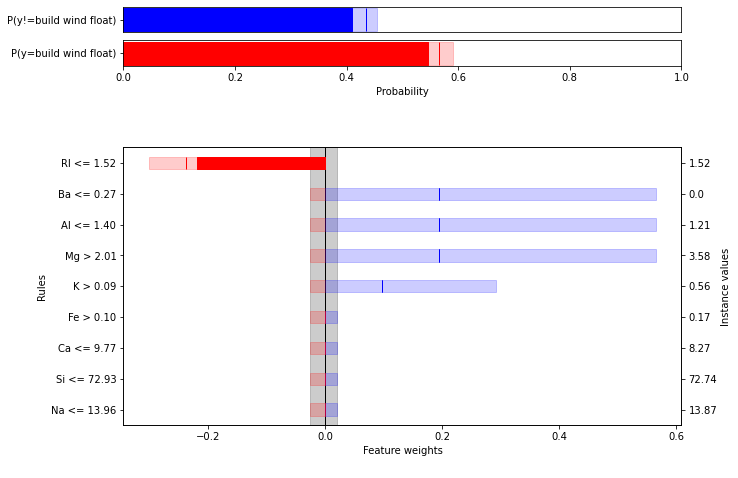

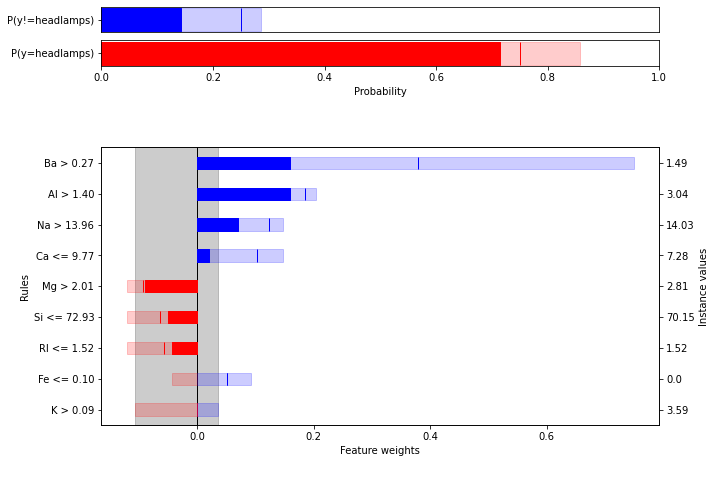

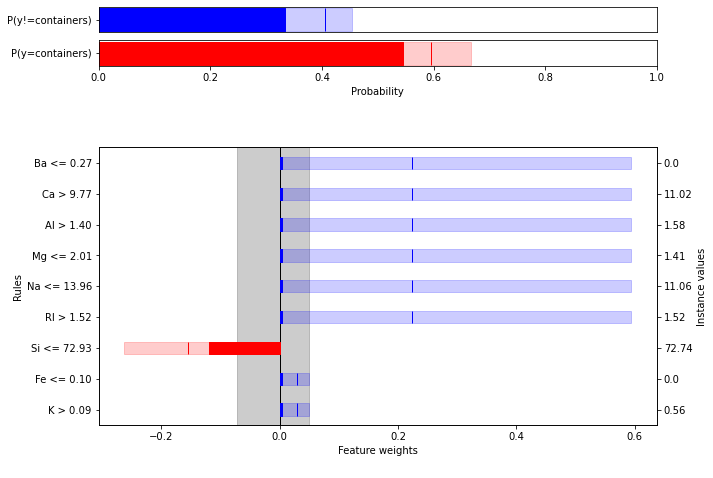

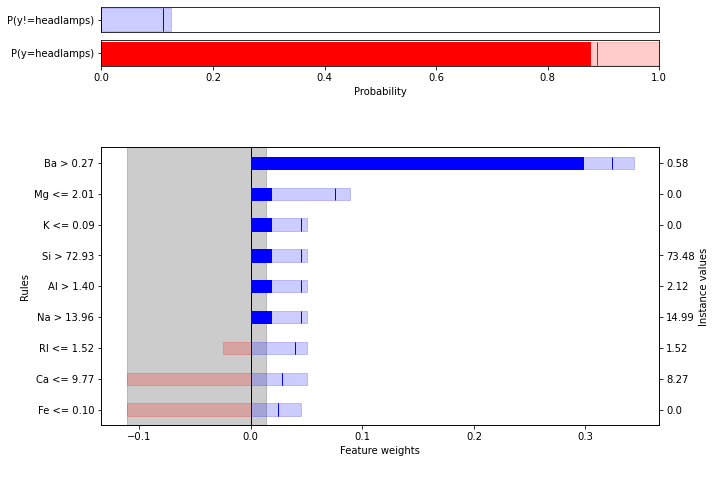

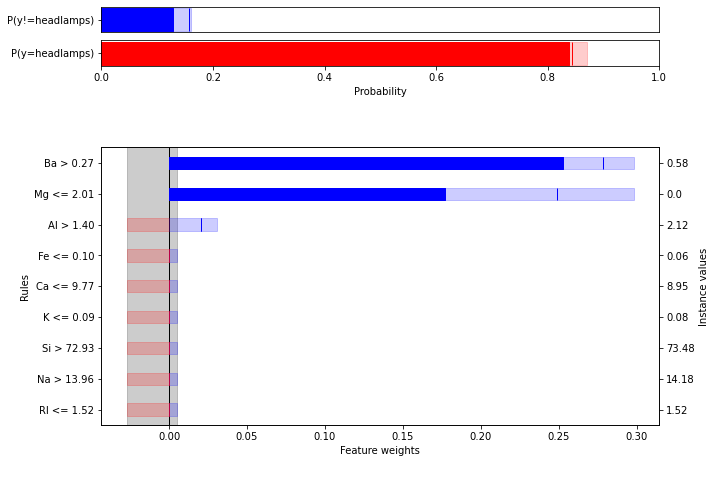

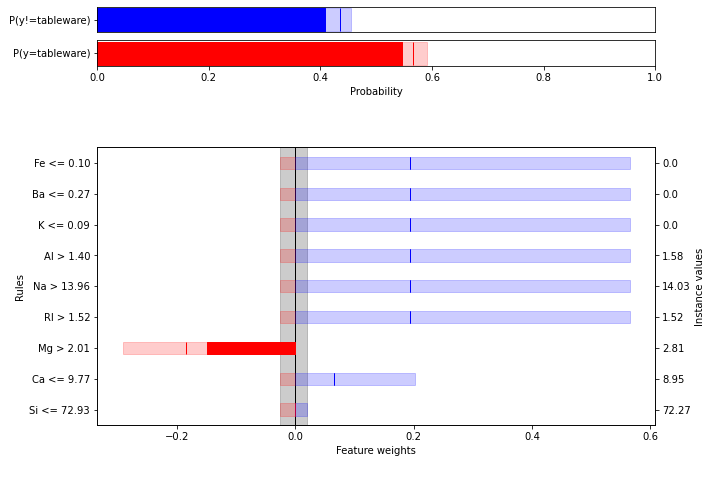

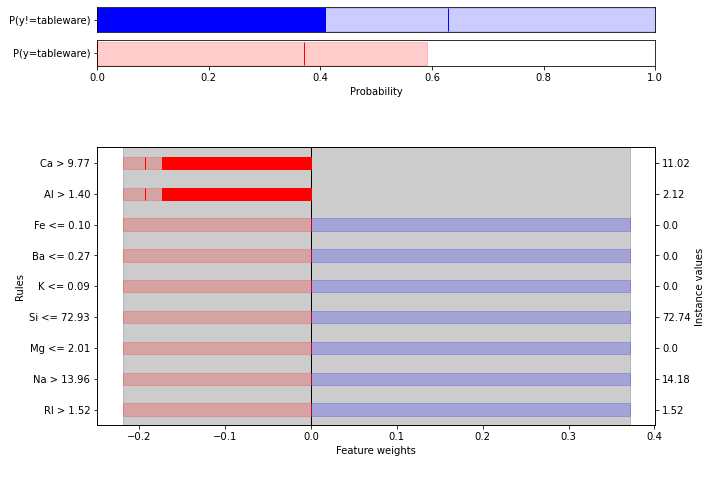

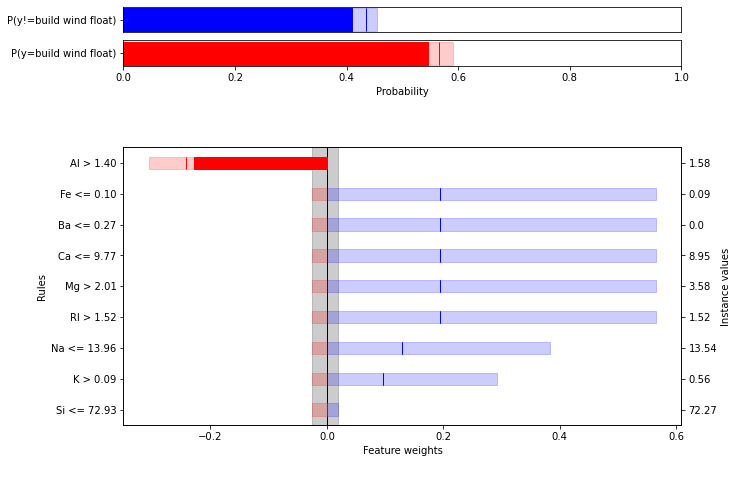

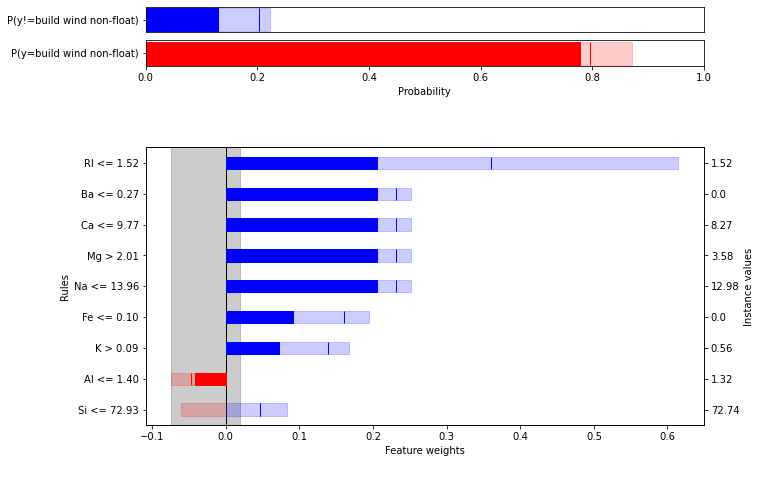

In [15]:
exp.remove_conjunctive_rules().plot_uncertainty()

In [16]:
exp = ce.get_counterfactuals(testX)

In [17]:
exp.remove_counterfactual_rules()
exp.add_conjunctive_counterfactual_rules()

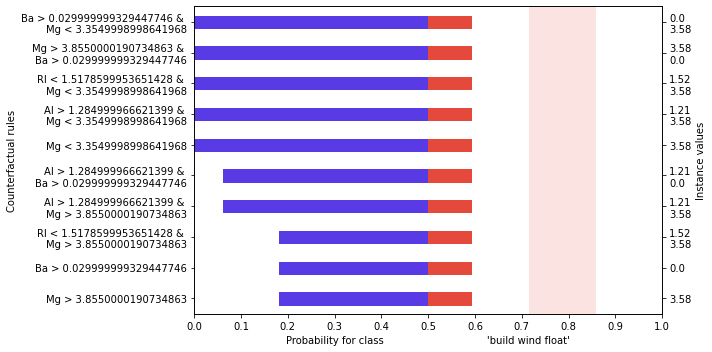

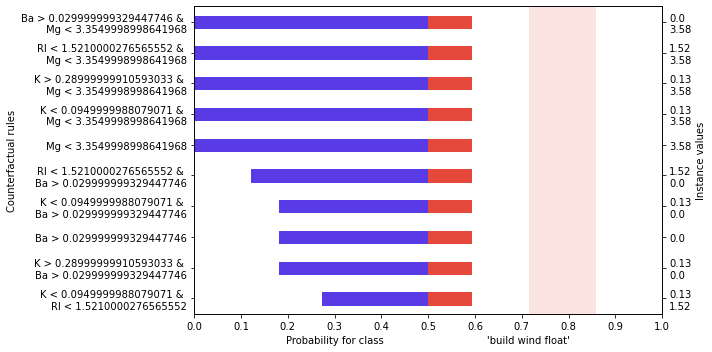

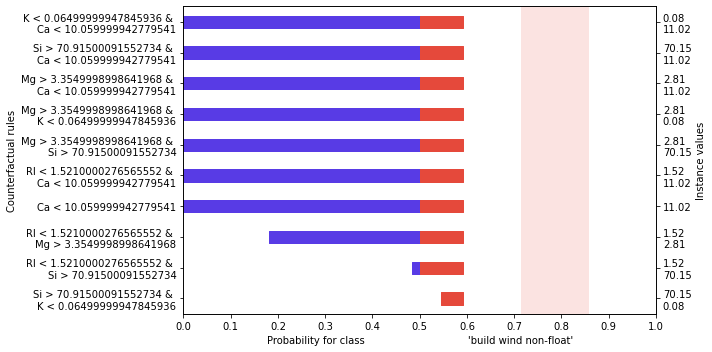

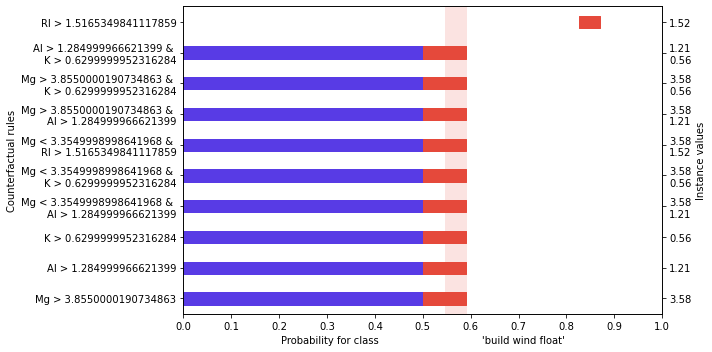

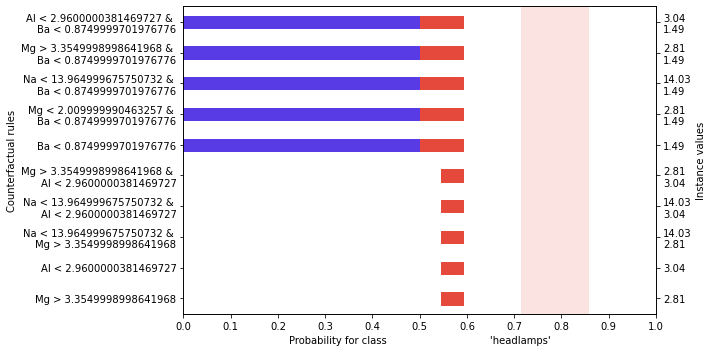

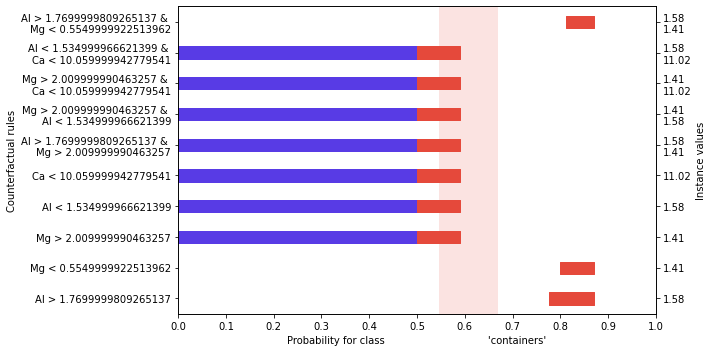

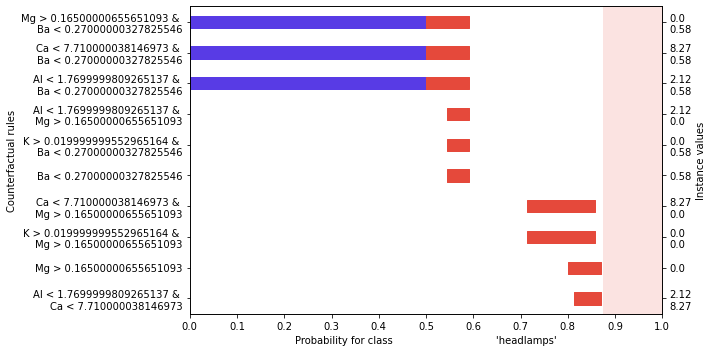

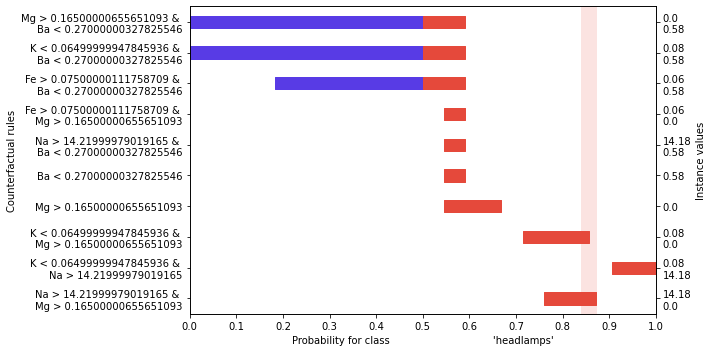

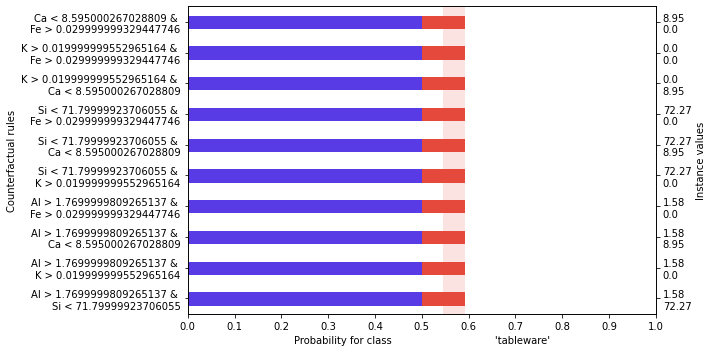

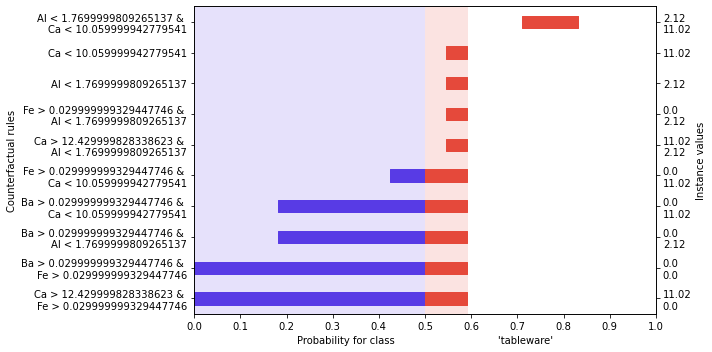

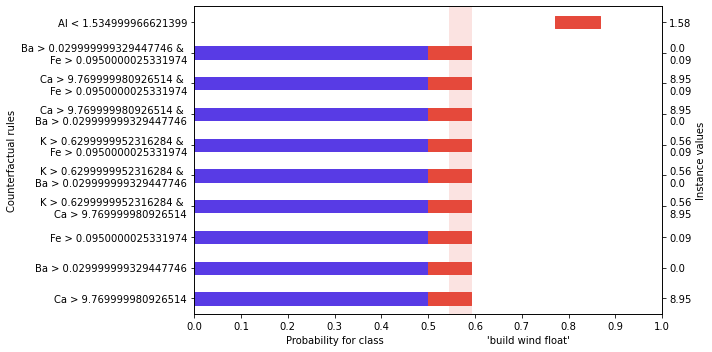

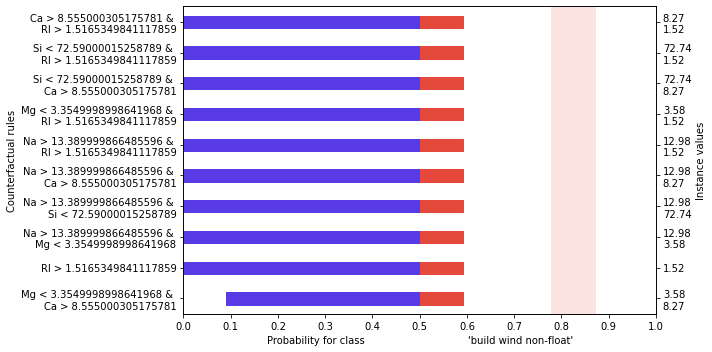

In [18]:
exp.plot_counterfactuals()